## Plotting how vocab_size affects the f_measure for BPE and ULM 

In [6]:
import matplotlib.pyplot as plt, numpy as np 
import json 
output_file = "outputs\\output.json"
with open(output_file, 'r') as f:
    output_dict = json.load(f)

output_data = output_dict["data"]
fscores_bpe = {}
fscores_ulm = {}
fscores_morfessor_len = {}

def extract_fscores(model_type, scores_dict):
    i = 0 
    for item in output_data:
        if model_type in item["model"]:
            parts = item["model"].split("_")
            for part in parts:
                if part.isdigit():
                    i = int(part) 
                    scores_dict[i] = float(item["f_measure"])

extract_fscores("bpe", fscores_bpe)
extract_fscores("ulm", fscores_ulm)
extract_fscores("morfessor_len", fscores_morfessor_len)

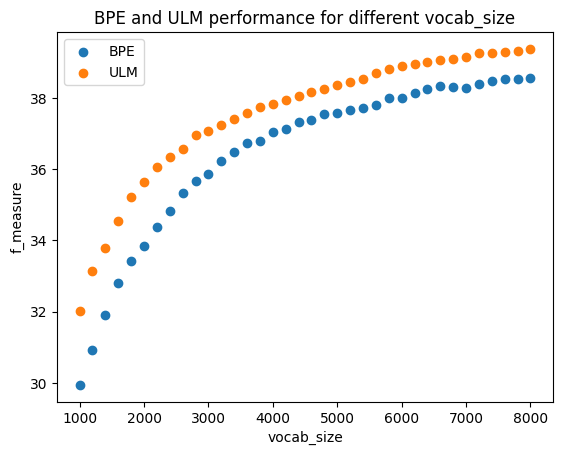

In [7]:
x = list(fscores_bpe.keys())
y1 = list(fscores_bpe.values())
y2 = list(fscores_ulm.values())
fig, ax = plt.subplots()
ax.set_xlabel('vocab_size')
ax.set_ylabel('f_measure')
ax.set_title('BPE and ULM performance for different vocab_size')
ax.scatter(x, y1, label='BPE')
ax.scatter(x, y2, label='ULM')
ax.legend()

## Plotting how --morph-length affects the f_measure for Morfessor 

<BarContainer object of 5 artists>

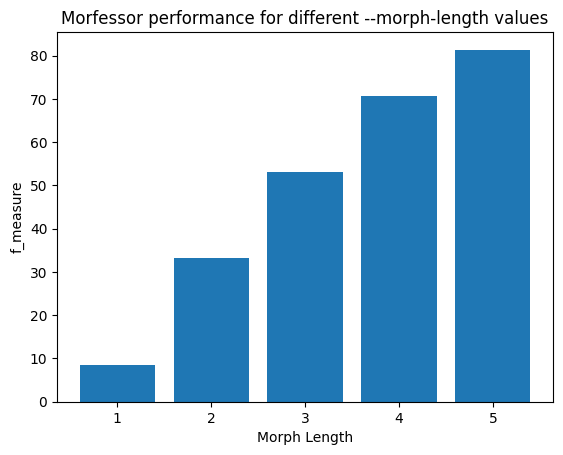

In [9]:
a = list(fscores_morfessor_len.keys())
b = list(fscores_morfessor_len.values())
fig, ax = plt.subplots()
ax.set_xlabel('Morph Length')
ax.set_ylabel('f_measure')
ax.set_title('Morfessor performance for different --morph-length values')
ax.bar(a,b)